In [1]:
import sys
import json
aggregation = {'distance':1000}
constant = {'cst_incline':1}
road_weight = {'residential':0.5,
            'secondary_link':0.3,
            'secondary':0.3,
            'tertiary':0.3,
            'cycleway':1.1,
            'primary':0.3,
            'motorway_link':0,
            'primary_link':0.3,
            'tertiary_link':0.3,
            'motorway':0,
            'trunk':0.2, 
            'trunk_link':0.2  
            }
shared_cycleway_weight = {'residential':0.8,
            'secondary_link':0.5,
            'secondary':0.5,
            'tertiary':0.5,
            'cycleway':1.1,
            'primary':0.5,
            'motorway_link':0,
            'primary_link':0.5,
            'tertiary_link':0.5,
            'motorway':0,
            'trunk':0.4, 
            'trunk_link':0.4   
        }

params = {'aggregation':aggregation,'constant':constant, 'road_weight': road_weight, 'shared_cycleway_weight': shared_cycleway_weight}

         

default = {'training_folder': '../../scenarios/quebec', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/quebec', 'params': {'aggregation': {'distance': 1000}, 'constant': {'cst_incline': 1}, 'road_weight': {'residential': 0.5, 'secondary_link': 0.3, 'secondary': 0.3, 'tertiary': 0.3, 'cycleway': 1.1, 'primary': 0.3, 'motorway_link': 0, 'primary_link': 0.3, 'tertiary_link': 0.3, 'motorway': 0, 'trunk': 0.2, 'trunk_link': 0.2}, 'shared_cycleway_weight': {'residential': 0.8, 'secondary_link': 0.5, 'secondary': 0.5, 'tertiary': 0.5, 'cycleway': 1.1, 'primary': 0.5, 'motorway_link': 0, 'primary_link': 0.5, 'tertiary_link': 0.5, 'motorway': 0, 'trunk': 0.4, 'trunk_link': 0.4}}}


In [2]:
import os
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.engine.road_model import RoadModel
from quetzal.engine.pathfinder_utils import get_path, parallel_dijkstra, build_index, sparse_matrix
from quetzal.engine.msa_utils import get_zone_index, assign_volume
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
from typing import Tuple
from geopy.distance import geodesic  # works for geopy version >=2
#from sklearn.cluster import KMeans
from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
from quetzal.engine.pathfinder_utils import simple_routing,get_path

num_cores = 1

In [3]:
def drop_duplicated_links(links: gpd.GeoDataFrame,
                          sort_column: str = 'maxspeed', 
                          ascending: bool = False, 
                          return_dropped:bool = False)-> Tuple[gpd.GeoDataFrame,list]:
    '''
    drop duplicated links (a,b) with condition sort_column. if maxspeed and ascending=False, keep faster road
    '''
    before = set(links.index)
    links['dup'] = links['a'] + links['b']
    links = links.sort_values(sort_column, ascending=ascending).drop_duplicates('dup').sort_index()
    links = links.drop(columns='dup')
    after = set(links.index)
    diff = list(before-after)
    print(len(diff), 'links dropped')
    return links, diff

def get_epsg(lat: float, lon: float) -> int:
    '''
    return EPSG in meter for a given (lat,lon)
    lat is north south 
    lon is est west
    '''
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))

def zones_nearest_node(zones,nodes,drop_duplicates=False):
    # getting zones centroids
    centroid = zones.copy()
    centroid['geometry'] = centroid.centroid
    # finding nearest node
    neigh = nearest(centroid, nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    centroid['node_index'] = centroid.index.map(zone_node_dict.get)
    print('max_distance found: ', neigh['distance'].max())
    # check for duplicated nodes. if there is. drop the duplicated zones.
    if drop_duplicates:
        if len(centroid.drop_duplicates('node_index')) != len(centroid):
            print('there is zones associates to the same road_node')
            # duplicated = centroid[centroid['node_index'].duplicated()]['node_index'].values
            print('dropping zones: ')
            print(centroid[centroid['node_index'].duplicated()].index.values)
            centroid = centroid.drop_duplicates('node_index')
    return centroid

def get_flight_distance(x):
    # inputs : [(lat,lon), (lat,lon)]. or [(y,x),(y,x)]
    # however. geodesic use lon,lat. so its inverted here

    
    return geodesic(x[0], x[1]).m

In [4]:
base_folder = argv['training_folder']
road_folder = base_folder + '/inputs/road/'
demand_folder = base_folder +'/inputs/'
od_folder = base_folder + '/inputs/od/'
output_folder = base_folder +'/outputs/'
print(road_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


../../scenarios/quebec/inputs/road/


# inputs

In [5]:
cst_incline = argv['params' ]['constant']['cst_incline']
cst_road = argv['params']['road_weight']
cst_shared = argv['params']['shared_cycleway_weight']

In [6]:
#make sure its float
cst_incline = float(cst_incline)
cst_road = {k:float(v) for k,v in cst_road.items()}
cst_shared = {k:float(v) for k,v in cst_shared.items()}

In [7]:
links = gpd.read_file(road_folder + 'road_links.geojson') 
nodes = gpd.read_file(road_folder + 'road_nodes.geojson')
links = links.set_index('index')
nodes = nodes.set_index('index')

In [8]:
demand = pd.read_csv(demand_folder+'demand.csv')
assert all([col in demand.columns for col in ['lon_ori','lat_ori','lon_des','lat_des','volume'] ]), 'need origin,destination and volume in demand'
demand = demand[['lon_ori','lat_ori','lon_des','lat_des','volume']]

In [9]:
od_test = gpd.read_file(od_folder + 'od.geojson')

In [10]:
if 'name' not in od_test.columns:
    od_test['name'] = od_test['index']
od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))

# agg demand

format demand and create zone

In [11]:
demand['origin'] = [*zip(demand['lon_ori'],demand['lat_ori'])]
demand['destination'] = [*zip(demand['lon_des'],demand['lat_des'])]
demand = demand.drop(columns=['lat_ori','lon_ori','lat_des','lon_des'])

In [12]:
# get unique zones
zones_set = set(demand['origin'].values).union(set(demand['destination'].values))
zones_dict = {val:'zone_'+str(i) for i,val in enumerate(zones_set)}
zones_df = [{'index':zone,'geometry':Point(val)} for val,zone in zones_dict.items()]

In [13]:
demand['origin'] = demand['origin'].apply(lambda x: zones_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: zones_dict.get(x))
zones = gpd.GeoDataFrame(zones_df,crs=4326).set_index('index')

Clustering

In [14]:
agg_dist = float(argv['params']['aggregation']['distance'])
epsg = get_epsg(zones.iloc[0]['geometry'].y, zones.iloc[0]['geometry'].x)
label = agglomerative_clustering(zones.to_crs(epsg), distance_threshold = agg_dist)
zones['cluster'] = label

In [15]:
print(len(zones),'zones agg to',len(zones['cluster'].unique()),' zones')

20000 zones agg to 626  zones


In [16]:
# create a dict zone:cluster
zones['cluster'] = 'zone_' + zones['cluster'].astype(str)
cluster_dict = zones['cluster'].to_dict()

In [17]:
# drop duplicated cluster and rename index with new cluster as zones_id
zones = zones.drop_duplicates('cluster')
zones = zones.set_index('cluster')
zones.index.name='index'

 AGG demand on new zones (volime is sum)

In [18]:
# apply new cluster fict to the demand
demand['origin'] = demand['origin'].apply(lambda x: cluster_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: cluster_dict.get(x))

In [19]:
demand = demand.groupby(['origin','destination']).agg(sum).reset_index()
demand.index.name = 'index'

# export zones and demand in outputs

In [20]:
#zones.to_file(output_folder + 'centroids.geojson',driver='GeoJSON')

In [21]:
# Group the DataFrame by "origin" and "destination", and then convert to JSON
grouped = demand.groupby(["origin", "destination"])["volume"].sum().reset_index()
json_data = {}
for _, row in grouped.iterrows():
    origin = row["origin"]
    destination = row["destination"]
    volume = row["volume"]
    if origin not in json_data:
        json_data[origin] = {}
    json_data[origin][destination] = volume

    
with open(output_folder + 'zones.json', 'w') as json_file:
    json.dump({'volume':json_data},json_file)

In [22]:
convex_hull = zones.unary_union.convex_hull.buffer(1e-3)
voronoi = voronoi_diagram_dataframes(zones['geometry'])
voronoi = gpd.GeoDataFrame(voronoi[0],crs=4326)
voronoi = voronoi.clip(convex_hull)
voronoi.to_file(output_folder + 'zones.geojson',driver='GeoJSON')

/home/boivin/.pyenv/versions/3.8.6/envs/quetzal_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [23]:
'''
def create_zones_from_nodes(nodes,num_zones=200):
    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)
    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)
    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')
    cluster.fit(nodes[['x','y']].values)
    geom = [Point(val) for val in cluster.cluster_centers_]
    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)
    zones.index = 'zone_' + zones.index.astype(str)
    return zones
#create_zones_from_nodes(zones).plot()
'''

"\ndef create_zones_from_nodes(nodes,num_zones=200):\n    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)\n    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)\n    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')\n    cluster.fit(nodes[['x','y']].values)\n    geom = [Point(val) for val in cluster.cluster_centers_]\n    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)\n    zones.index = 'zone_' + zones.index.astype(str)\n    return zones\n#create_zones_from_nodes(zones).plot()\n"

# split oneway quenedi links

In [24]:
# split quenedi road links
self = RoadModel(links,nodes,zones,ff_time_col='time')

In [25]:

print('split rlinks to oneways')
self.split_quenedi_rlinks()
#self.zones_nearest_node()

split rlinks to oneways


In [26]:
links = self.road_links
del self

# tag cycleways

In [27]:
index = [idx for idx in links.index if not idx.endswith('_r')]
index_r = [idx for idx in links.index if idx.endswith('_r')]
assert len(index)+len(index_r) == len(links)

In [28]:
# inverted links cycleway is the reverse one
links.loc[index_r,'cycleway'] = links.loc[index_r,'cycleway_reverse'] 

In [29]:
links['isroad'] = True
ls = links['cycleway'].isin(['yes','shared'])
links.loc[ls,'isroad'] = False


# inclines

In [30]:
links['incline'] = links['incline'].astype(float)
links['incline'] = links['incline'].fillna(0)


In [31]:
# reverse incline on reversed links
links.loc[index_r,'incline'] = -links.loc[index_r,'incline']
#create this column for vizualisation
links['incline (abs)'] = abs(links['incline'])

# apply Weight

In [32]:
# incline weigth (starting point)
links['eff_speed'] = 20  * (1 - cst_incline * np.sin(np.deg2rad(links['incline'])))


In [33]:
# derate it with road weight
links['cst_road'] = links['highway'].apply(lambda x: cst_road.get(x,1))
links.loc[links['isroad'],'eff_speed'] = links.loc[links['isroad'],'eff_speed'] * links.loc[links['isroad'],'cst_road']

In [34]:
# derate it with shared cycleway weight
links['cst_shared'] = links['highway'].apply(lambda x: cst_shared.get(x,1))

ls = links.loc[links['cycleway']=='shared'].index
links.loc[ls,'eff_speed'] = links.loc[ls,'eff_speed'] * links.loc[ls,'cst_shared']


transform effective speed to a weight

In [35]:
# anything with neg speed round to 0. (dijkstra need positive weight)
links['eff_speed'] = links['eff_speed'].apply(lambda x : max(x,0))

In [36]:
links['weight'] = links['length']/(links['eff_speed']*1000/3600)

In [37]:
links = links.drop(columns=['cst_road','cst_shared'])

# zone to nodes

get the list of nodes with weight != inf. we do not want to route from or to nodes that are not cycle (ex motorway)

In [38]:
tlinks = links[np.isfinite(links['weight'])][['a','b']]
nodes_set = set(tlinks['a']).union(set(tlinks['b']))
possible_nodes = nodes.loc[list(nodes_set)].sort_index()
del tlinks,nodes_set

In [39]:
zones = zones_nearest_node(zones, possible_nodes)

/tmp/ipykernel_316824/529603176.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid['geometry'] = centroid.centroid


max_distance found:  0.022534254147859218


# Shortest path + volume assignment

In [40]:
zones_nodes_dict = zones['node_index'].to_dict()
demand['o_zone'] = demand['origin']
demand['d_zone'] = demand['destination']
demand['origin'] = demand['origin'].apply(lambda x: zones_nodes_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: zones_nodes_dict.get(x))

In [41]:
df = links[['a', 'b','weight']].copy()

In [42]:
df, dropped = drop_duplicated_links(df,sort_column='weight',ascending=False)

316 links dropped


In [43]:
edges = df[['a', 'b', 'weight']].values  # to build the index once and for all
index = build_index(edges)
reversed_index = {v: k for k, v in index.items()}
# apply sparse index on zones
demand, zones_indices = get_zone_index(df, demand, index)

In [44]:
# apply sparse index on links
df['sparse_a'] = df['a'].apply(lambda x: index.get(x))
df['sparse_b'] = df['b'].apply(lambda x: index.get(x))
volumes_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))

odv = demand[['o', 'd', 'volume']].values

In [45]:
edges = df[['a', 'b', 'weight']].values
sparse, _ = sparse_matrix(edges, index=index)
time_matrix, predecessors = parallel_dijkstra(sparse,
                                              directed=True,
                                              indices=zones_indices,
                                              return_predecessors=True,
                                              num_core=num_cores,
                                              keep_running=True)

# this give OD_time/time_matrix on each links. then X links time for the ratio links_time/tot_time


In [46]:
ab_volumes = assign_volume(odv,predecessors,volumes_sparse_keys,reversed_index)

restrict links to df.index (dropped duplicated links). if not. volume will not be assign on the right link (when duplicated) or, maybe on both.

In [47]:
links['volume'] = 0
links.loc[df.index,'volume'] = links.loc[df.index].set_index(['a', 'b']).index.map(ab_volumes.get)

In [48]:
col_r = [col for col in links.columns if col.endswith('_r')]
links = links.drop(columns=col_r)
links = links.drop(columns=['isroad'])

# exporting loaded Links

In [49]:
links.to_file(output_folder + 'loaded_links.geojson',driver='GeoJSON')

# OD test

In [50]:
od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))

In [51]:
# find nearest node with KNN. nodes are now the origin and destination.
od_test['geometry'] = od_test['geometry_o']
neigh = nearest(od_test, possible_nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
od_test['origin'] = od_test.index.map(zone_node_dict.get)

od_test['geometry'] = od_test['geometry_d']
neigh = nearest(od_test, possible_nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
od_test['destination'] = od_test.index.map(zone_node_dict.get)

od_test = od_test.drop(columns=['geometry_o','geometry_d','geometry'])

In [52]:
o_nodes = od_test['origin'].values
d_nodes = od_test['destination'].values

time_mat, predecessors, node_index = simple_routing(o_nodes,d_nodes,links,weight_col='weight',return_predecessors=True)
reversed_index = {v: k for k, v in node_index.items()}

links_dict = links.reset_index().set_index(['a','b'])['index'].to_dict()

routes = gpd.GeoDataFrame()
for o,d in  enumerate(od_test['destination'].values):
    path = get_path(predecessors, o, node_index[d])
    path = list(zip(path[:-1], path[1:]))

    path = [(reversed_index[k[0]], reversed_index[k[1]]) for k in path]
    path = [*map(links_dict.get,path)]

    route = links.loc[path]
    route['od_name'] =  od_test.iloc[o]['name']
    routes = pd.concat([routes,route])

# export OD routes

In [53]:
routes.to_file(output_folder + 'od_routes.geojson',driver='GeoJSON')

#  kpis

network

In [54]:
links['volkm'] = links['volume']*links['length']/1000
res = links.groupby('cycleway')[['volkm']].agg(sum)
#res['volkm'].plot.pie()

res = res.T.fillna(0)
res.columns = res.columns+' (km)'
res = res.rename(index={'volkm':'network'})

res['cycle (km)'] = res.sum(axis=1)

res['no (%)'] = 100* res['no (km)'] / res['cycle (km)']
res['shared (%)'] = 100* res['shared (km)'] / res['cycle (km)']
res['yes (%)'] = 100* res['yes (km)'] / res['cycle (km)']

In [55]:
# crow fligh
geom_dict = add_geometry_coordinates(zones)[['y_geometry','x_geometry']].apply(tuple,axis=1).to_dict()
demand['distance'] = demand[['o_zone','d_zone']].apply(lambda x: get_flight_distance([*map(geom_dict.get, x.values)]), axis=1)
res['crow (km)'] = sum(demand['volume'] * demand['distance'])/1000

In [56]:
res['cycle-crow (km)'] = res['cycle (km)'] - res['crow (km)']
res['cycle/crow (%)'] = 100 * res['cycle (km)']/ res['crow (km)']

In [57]:
res.to_csv(output_folder+'network_kpi.csv')

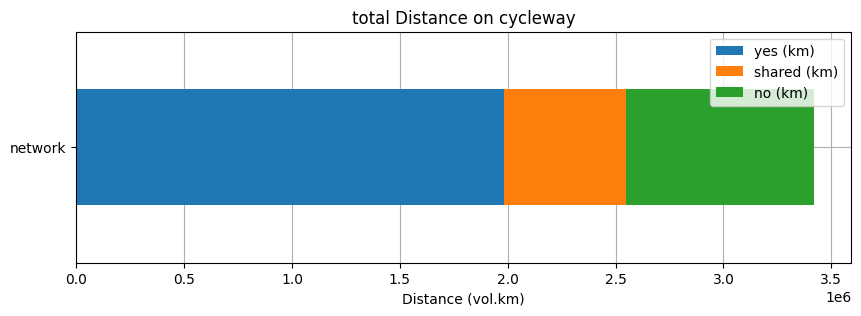

In [58]:
ax = res[['yes (km)', 'shared (km)', 'no (km)']].plot(kind='barh',stacked=True,figsize=(10, 3))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('total Distance on cycleway')
plt.savefig(output_folder+'total_distance_km.png')

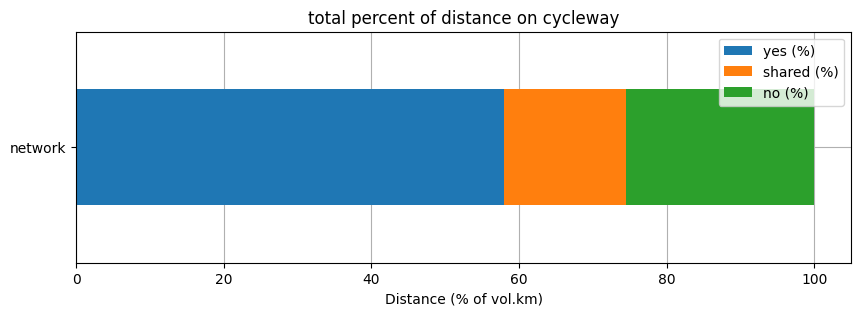

In [59]:
ax = res[['yes (%)', 'shared (%)', 'no (%)']].plot(kind='barh',stacked=True,figsize=(10, 3))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (% of vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('total percent of distance on cycleway')
plt.savefig(output_folder+'total_distance_percent.png')

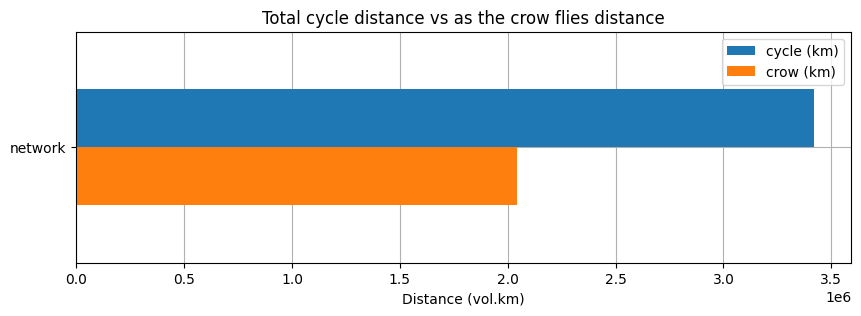

In [60]:
ax = res[['cycle (km)','crow (km)']].plot(kind='barh',stacked=False,figsize=(10, 3))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Total cycle distance vs as the crow flies distance')
plt.savefig(output_folder+'total_cycle_vs_crow.png')

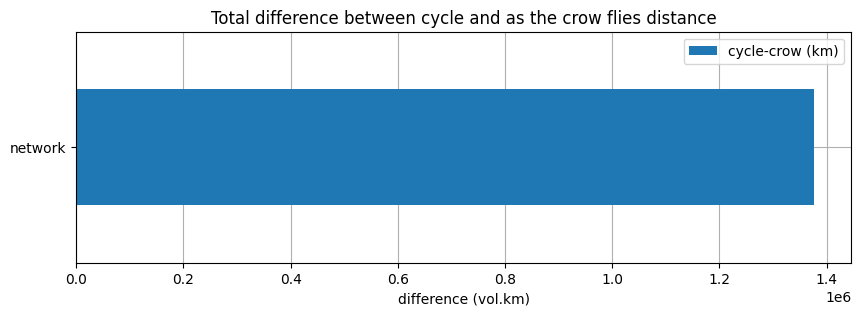

In [61]:
ax = res[['cycle-crow (km)']].plot(kind='barh',stacked=False,figsize=(10, 3))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("difference (vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Total difference between cycle and as the crow flies distance')
plt.savefig(output_folder+'total_diff_cycle_crow.png')

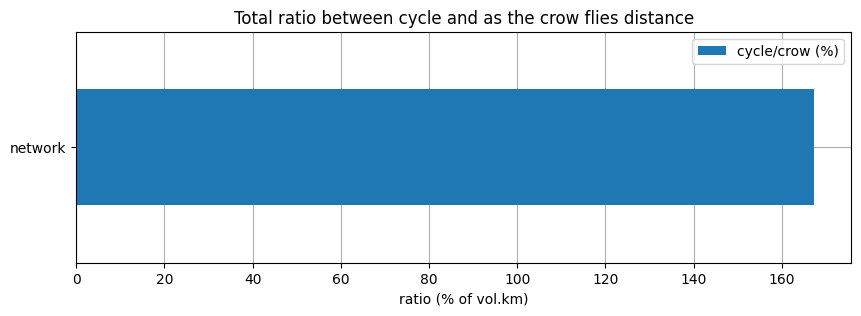

In [62]:
ax = res[['cycle/crow (%)']].plot(kind='barh',stacked=False,figsize=(10, 3))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("ratio (% of vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Total ratio between cycle and as the crow flies distance')
plt.savefig(output_folder+'total_ratio_cycle_crow.png')

# KPI  per OD

In [96]:
res = routes.groupby(['od_name','cycleway'])[['length']].agg(sum)/1000

res = res.unstack().fillna(0)
res.columns = res.columns.levels[1]
res.columns = res.columns+' (km)'

res['cycle (km)'] = res.sum(axis=1)

res['no (%)'] = 100* res['no (km)'] / res['cycle (km)']
res['shared (%)'] = 100* res['shared (km)'] / res['cycle (km)']
res['yes (%)'] = 100* res['yes (km)'] / res['cycle (km)']

In [97]:
geom_dict = add_geometry_coordinates(nodes)[['y_geometry','x_geometry']].apply(tuple,axis=1).to_dict()
od_test['crow (km)'] = od_test[['origin','destination']].apply(lambda x: get_flight_distance([*map(geom_dict.get, x.values)]), axis=1)/1000
tmp_dict = od_test.set_index('name')['crow (km)'].to_dict()
res['crow (km)'] = res.index.map(tmp_dict.get)

In [98]:
res['cycle-crow (km)'] = res['cycle (km)'] - res['crow (km)']
res['cycle/crow (%)'] = 100 * res['cycle (km)']/ res['crow (km)']

In [99]:
res.to_csv(output_folder+'od_kpi.csv')

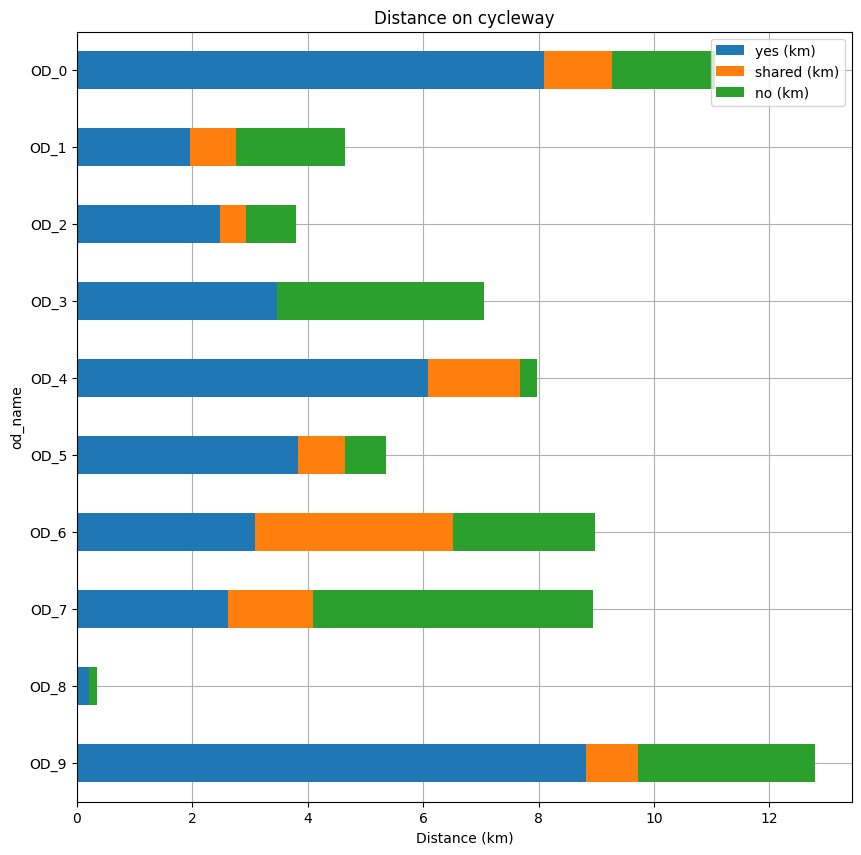

In [100]:
ax = res[['yes (km)', 'shared (km)', 'no (km)']].plot(kind='barh',stacked=True,figsize=(10, 10))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Distance on cycleway')
plt.savefig(output_folder+'od_distance_km.png')

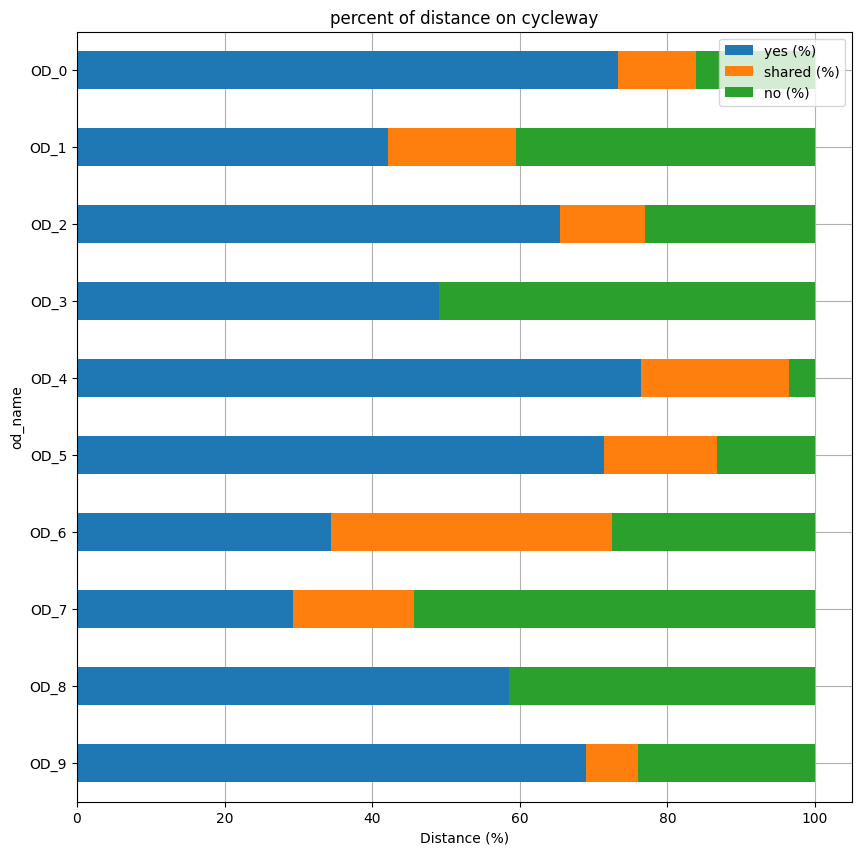

In [102]:
ax = res[['yes (%)', 'shared (%)', 'no (%)']].plot(kind='barh',stacked=True,figsize=(10, 10))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (%)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('percent of distance on cycleway')
plt.savefig(output_folder+'od_distance_percent.png')

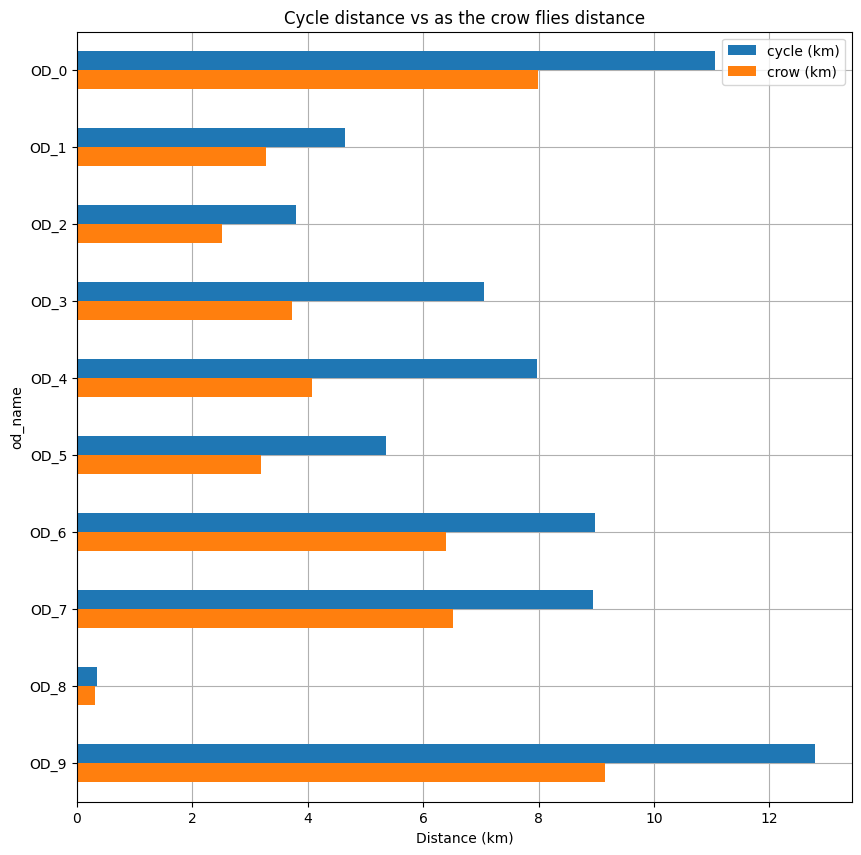

In [69]:
ax = res[['cycle (km)','crow (km)']].plot(kind='barh',stacked=False,figsize=(10, 10))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Cycle distance vs as the crow flies distance')
plt.savefig(output_folder+'od_cycle_vs_crow.png')

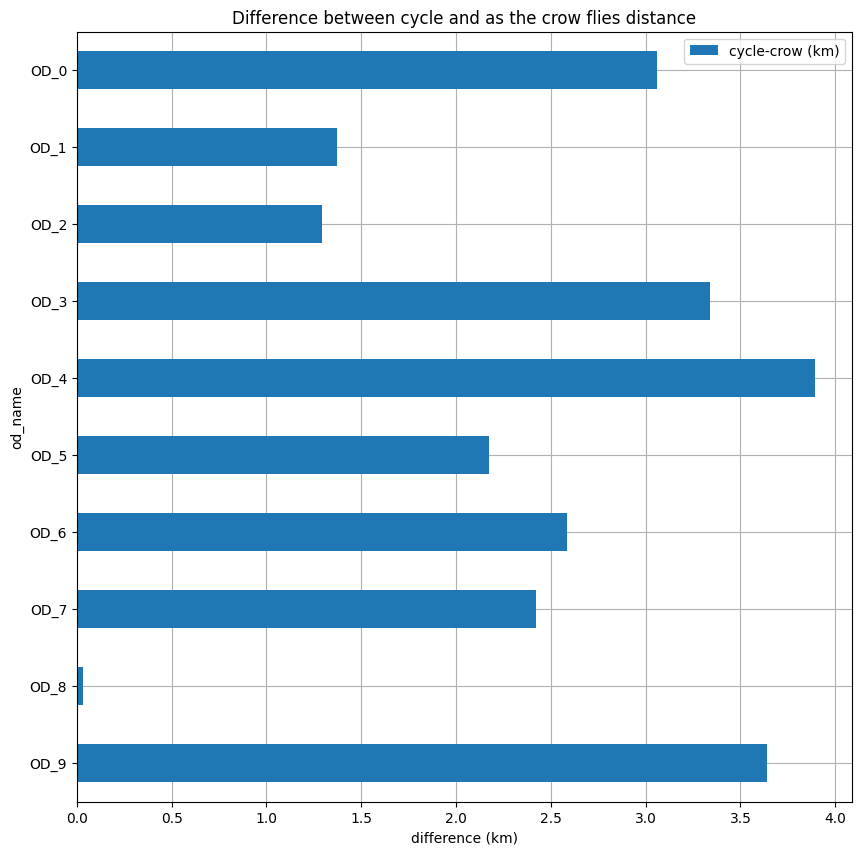

In [70]:
ax = res[['cycle-crow (km)']].plot(kind='barh',stacked=False,figsize=(10, 10))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("difference (km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Difference between cycle and as the crow flies distance')
plt.savefig(output_folder+'od_diff_cycle_crow.png')

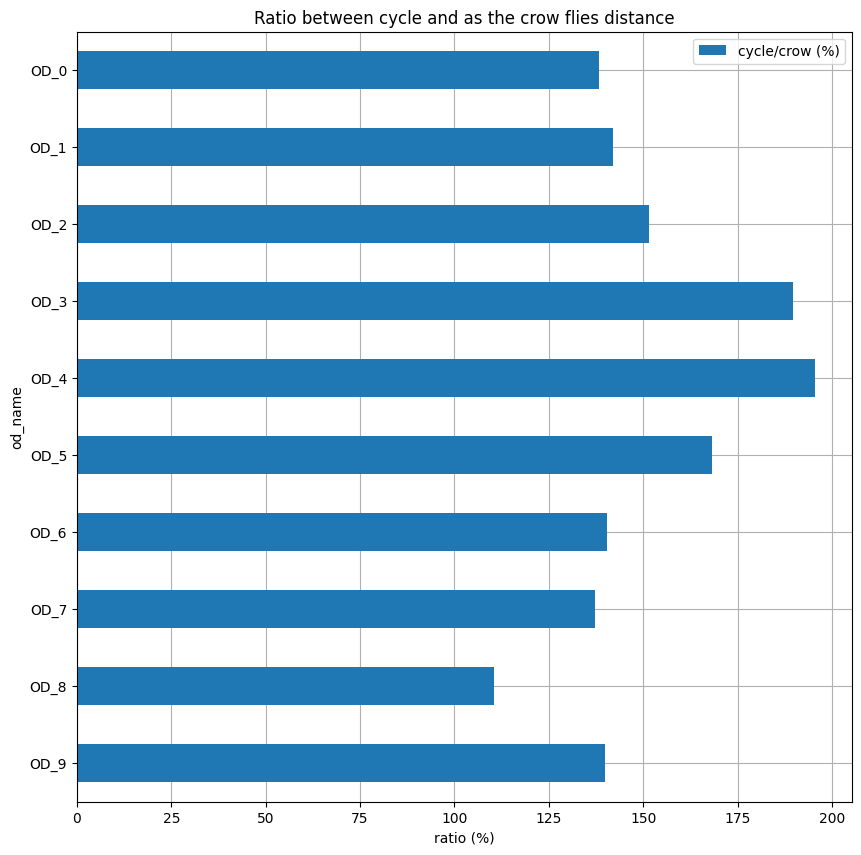

In [71]:
ax = res[['cycle/crow (%)']].plot(kind='barh',stacked=False,figsize=(10, 10))
plt.legend(loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("ratio (%)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Ratio between cycle and as the crow flies distance')
plt.savefig(output_folder+'od_ratio_cycle_crow.png')

cycleway,no (km),shared (km),yes (km),cycle (km),no (%),shared (%),yes (%),crow (km),cycle-crow (km),cycle/crow (%)
od_name,,,,,,,,,,
OD_0,1.778303,1.180666,8.098711,11.057680,16.082065,10.677336,73.240599,7.995635,3.062045,138.296459
OD_1,1.882050,0.806519,1.958596,4.647165,40.498893,17.355065,42.146042,3.274528,1.372637,141.918633
OD_2,0.876624,0.439045,2.485002,3.800671,23.064980,11.551772,65.383248,2.509922,1.290749,151.425882
OD_3,3.595038,0.000000,3.466590,7.061628,50.909482,0.000000,49.090518,3.722994,3.338633,189.676028
OD_4,0.284005,1.600263,6.085835,7.970104,3.563380,20.078322,76.358297,4.076363,3.893740,195.519958
OD_5,0.715432,0.814850,3.835055,5.365338,13.334335,15.187304,71.478360,3.189066,2.176272,168.241676
OD_6,2.472906,3.417040,3.094388,8.984334,27.524645,38.033315,34.442040,6.400247,2.584087,140.374804
OD_7,4.853931,1.471587,2.614299,8.939817,54.295646,16.461037,29.243317,6.517554,2.422263,137.165208
OD_8,0.143657,0.000000,0.202749,0.346406,41.470777,0.000000,58.529223,0.313598,0.032808,110.461937


# end

# merging

In [209]:
'''
def merge_quenedi_rlinks(road_links,new_col):
    if 'oneway' not in road_links.columns:
        print('no column oneway. do not merge')
        return
    #get reversed links
    index_r = [idx for idx in road_links.index if idx.endswith('_r')]
    if len(index_r) == 0:
        print('all oneway, nothing to merge')
        return
    links_r = road_links.loc[index_r].copy()
    # create new reversed column with here speed and time
    links_r[new_col + '_r'] = links_r[new_col]
    # reindex with initial non _r index to merge
    links_r.index = links_r.index.map(lambda x: x[:-2])
    links_r = links_r[[new_col + '_r']]
    # drop added _r links, merge new here columns to inital two way links.
    road_links = road_links.drop(index_r, axis=0)
    # drop column if they exist before merge. dont want duplicates
    if new_col + '_r' in road_links.columns:
        road_links = road_links.drop(columns=new_col + '_r')
    road_links = pd.merge(road_links, links_r, left_index=True, right_index
                                =True, how='left')
    return road_links
'''

"\ndef merge_quenedi_rlinks(road_links,new_col):\n    if 'oneway' not in road_links.columns:\n        print('no column oneway. do not merge')\n        return\n    #get reversed links\n    index_r = [idx for idx in road_links.index if idx.endswith('_r')]\n    if len(index_r) == 0:\n        print('all oneway, nothing to merge')\n        return\n    links_r = road_links.loc[index_r].copy()\n    # create new reversed column with here speed and time\n    links_r[new_col + '_r'] = links_r[new_col]\n    # reindex with initial non _r index to merge\n    links_r.index = links_r.index.map(lambda x: x[:-2])\n    links_r = links_r[[new_col + '_r']]\n    # drop added _r links, merge new here columns to inital two way links.\n    road_links = road_links.drop(index_r, axis=0)\n    # drop column if they exist before merge. dont want duplicates\n    if new_col + '_r' in road_links.columns:\n        road_links = road_links.drop(columns=new_col + '_r')\n    road_links = pd.merge(road_links, links_r, left

In [108]:
#links = merge_quenedi_rlinks(links,'volume')

# test

In [93]:
import six
import numpy as np
import matplotlib.pyplot as plt

class Current:
    def __init__(self):
        self.s = ''
        
    def replace_seen(self, s):
        if self.s == s:
            to_return = ''
        else :
            to_return = s 
        self.s = s
        return to_return

def label_index(data):
    ix_name = data.index.name
    c_name = data.columns.name 
    t = data.copy()
    if c_name is not None:
        t.index.name = c_name
    if ix_name is not None:
        ix = list(data.index)
        t = t.reindex([ix_name] + list(ix))
        t = t.fillna('')
    return t

def render_mpl_table(
    data, 
    col_width=3.0, 
    row_height=0.625, 
    font_size=14,
    header_size=14,
    index_width_ratio=2,
    header_color='#9d1a1e', 
    header_font_color = 'w',
    sub_header_color='#d22328',
    row_colors=['#f1f1f2', 'w'], 
    edge_color='w',
    index_edge_color='#9d1a1e',
    bbox=[0, 0, 1, 1], 
    header_columns=0,
    figsize=None,
    ax=None, 
    dpi=96,
    **kwargs
):
    #c_levels = len(data.columns.names)
    #c_first = data.columns.names[0]
    
    
    i_levels = len(data.index.names)
    i_first = list(data.index.names)[0]

    data = data.reset_index()
    current = Current()
    try:
        data[i_first] = data[i_first].apply(lambda s: current.replace_seen(s))
    except KeyError:
        pass

    
    if figsize:
        col_width = figsize[0] / (len(data.T) + (index_width_ratio - 1))
        row_height = figsize[1] / (len(data) +1)
        
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size, dpi=dpi)
        ax.axis('off')

    mpl_table = ax.table(
        cellText=data.values, 
        bbox=bbox, 
        colLabels=data.columns, 
        colWidths= [col_width * index_width_ratio ] + [col_width for c in data.columns[1:]],
        **kwargs
    )

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(index_edge_color)
        if k[0] < 1 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color=header_font_color)

            cell.set_text_props( color=header_font_color)
            cell.set_fontsize(header_size)
            cell.set_facecolor(header_color)

        elif k[1] < i_levels:
            cell.set_text_props(weight='bold', color=header_font_color)
            cell.set_text_props( color=header_font_color)
            cell.set_fontsize(header_size)
            cell.set_facecolor(sub_header_color)
        else:
            cell.set_edgecolor(edge_color)
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [94]:


import unicodedata

def normalize(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode().replace(' ', '_').lower().replace(',', '')

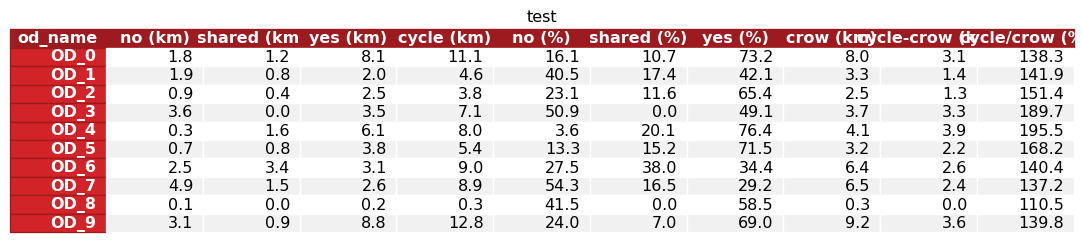

In [95]:
# PLOT

data = res.copy()
data = np.round(data, 1).applymap(float)
plot = render_mpl_table(
    data, 
    header_size=12, font_size=12, 
    row_height=0.25, col_width=1.3, index_width_ratio=1,
)
title = 'test'
plot.set_title(title , fontsize=12)
file = output_folder+'{title}.png'.format(title=normalize(title))
plot.get_figure().savefig(file, bbox_inches='tight')

Text(0.5, 1.0, 'Cycle distance vs as the crow flies distance')

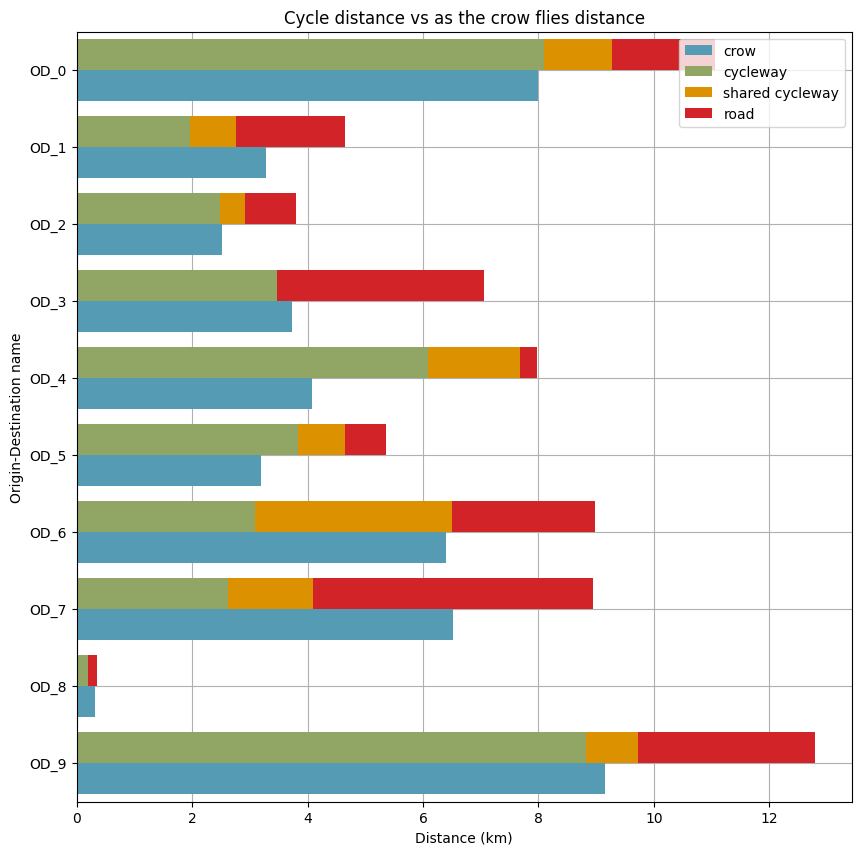

In [209]:
colors=["#559BB4","#91A564","#DC9100","#D22328","#8C4B7D"]
fig, ax = plt.subplots(figsize=(10,10))
res['crow (km)'].plot(kind='barh',ax=ax, color=colors[0], position=0,width=0.4)
res[['yes (km)', 'shared (km)', 'no (km)']].plot(kind='barh',stacked=True, ax=ax,position=1,width=0.4,color=colors[1:])
len(res)
plt.ylim([-0.5,len(res)-0.5])
plt.legend(['crow', 'cycleway','shared cycleway', 'road'],loc="upper right", ncol=1)
plt.gca().invert_yaxis()
plt.xlabel("Distance (km)")
plt.ylabel('Origin-Destination name')
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Cycle distance vs as the crow flies distance')